In [4]:
import pandas as pd
import numpy as np
import numpy.linalg as la
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.base import clone
import timeit
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings

In [5]:
def pca(F, X):
    n, d = X.shape
    mu = np.zeros((d, 1))
    Z = np.zeros((d, F))
    for i in range(d):
        mu[i] = (1. / n) * np.sum(X[:, [i]])
    X = X - mu.T
    U, s, Vt = la.svd(X, False)
    g = s[:F]
    for i in range(F):
        g[i] = 1. / g[i]
    W = Vt[:F]
    Z = np.dot(W.T, np.diag(g))
    return (mu, Z)

def pca_proj(X,mu,Z):
    n, d = X.shape
    X = X - mu.T
    return np.dot(X, Z)

In [6]:
def k_fold(k, model, f, X, y, error_type="mse"):
    n, d = X.shape
    z = np.zeros((k, 1))
    for i in range(k):
        T = list(range(int((i * n) / k), int((n * (i + 1) / k))))
        S = [j for j in range(n) if j not in T]
        curr_model = clone(model)

        training_mu, training_Z = pca(f, X[S])
        training_X = pca_proj(X[S], training_mu, training_Z)

        curr_model.fit(training_X, y[S])

        test_X = pca_proj(X[T], training_mu, training_Z)

        # y[T] will be len(T) by 1
        # X[T] will be len(T) by d
        if error_type == "mse":
            z[i] = (1. / len(T)) * np.sum((y[T] - curr_model.predict(test_X)) ** 2)
        elif error_type == "log_mse":
            z[i] = (1. / len(T)) * np.sum((np.log(y[T] + 1) - np.log(curr_model.predict(test_X) + 1)) ** 2)
    return z

In [7]:
def bootstrapping(B, model, f, X, y, error_type="mse"):
    n, d = X.shape
    z = np.zeros((B, 1))
    for i in range(B):
        u = np.random.choice(n, n, replace=True)
        S = np.unique(u)
        T = np.setdiff1d(np.arange(n), S, assume_unique=True)
        curr_model = clone(model)

        training_mu, training_Z = pca(f, X[u])
        training_X = pca_proj(X[u], training_mu, training_Z)

        curr_model.fit(training_X, y[u])

        test_X = pca_proj(X[T], training_mu, training_Z)

        # y[T] will be len(T) by 1
        # X[T] will be len(T) by d
        # theta_hat will be d by 1
        if error_type == "mse":
            z[i] = (1. / len(T)) * np.sum((y[T] - curr_model.predict(test_X)) ** 2)
        elif error_type == "log_mse":
            z[i] = (1. / len(T)) * np.sum((np.log(y[T] + 1) - np.log(curr_model.predict(test_X) + 1)) ** 2)
    return z

In [8]:
def evaluate_model(model, f, X, y, k=5, B=5, error = "mse"):
    ########################KFOLD###################
    print('Evaluating K-fold with %d folds.' % k)
    start_time = timeit.default_timer()
    k_fold_z = k_fold(k, model, f, X, y, error_type=error)
    elapsed = timeit.default_timer() - start_time
    
    k_fold_mse = np.mean(k_fold_z)
    print('K-fold %s: ' % error, k_fold_mse)
    
    k_fold_rmse = math.sqrt(k_fold_mse)
    print('K-fold Square Root %s: ' % error, k_fold_rmse)

    print("Time elapsed for k-fold: ", elapsed)
    
    print()
    print()
    ###################BOOTSTRAPPING################
    print('Evaluating bootstrapping with %d bootstraps.' % B)
    start_time = timeit.default_timer()
    bootstrapping_z = bootstrapping(B, model, f, X, y)
    elapsed = timeit.default_timer() - start_time
    
    bootstrapping_mse = np.mean(bootstrapping_z)
    print('Bootstrapping Mean Squared Error: ', bootstrapping_mse)
    
    bootstrapping_rmse = math.sqrt(bootstrapping_mse)
    print('Bootstrapping Square Root Mean Squared Error: ', bootstrapping_rmse)

    print("Time elapsed for bootstrapping: ", elapsed)
    
    return (k_fold_z, k_fold_mse, k_fold_rmse, bootstrapping_z, bootstrapping_mse, bootstrapping_rmse)

# Loading and Processing Data

In [9]:
kaggle_train = pd.read_csv("train.csv", header=0)
kaggle_test = pd.read_csv("test.csv", header=0)

kaggle_train_X = kaggle_train.iloc[:,:-1]
kaggle_train_y = kaggle_train.iloc[:,-1:]

print(kaggle_train_X.shape)
print(kaggle_train_y.shape)
print(kaggle_test.shape)

(1460, 80)
(1460, 1)
(1459, 80)


## Joins Kaggle Train and Test data together so we can encode at once.

In [10]:
X_full = kaggle_train_X.append(kaggle_test, ignore_index=True)

## Drops columns that have more than 40% null values.

In [11]:
cols_to_drop = []
data_keys = X_full.keys()
for i, b in enumerate((X_full.isnull().sum() / X_full.shape[0]) > 0.4):
    if b:
        cols_to_drop.append(data_keys[i])

X_full_dropped = X_full.drop(cols_to_drop, axis=1)

In [12]:
cols_to_drop

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

## Runs one hot encoding for categorical columns.

In [13]:
catCols = set(X_full_dropped.select_dtypes(include=['object']))

In [14]:
frames = []
for col in catCols:
    oneHot_encoded = pd.get_dummies(X_full_dropped[col])
    oneHot_encoded = oneHot_encoded.add_prefix(col + '_is_')
    frames.append(oneHot_encoded)

X_full_ohe = X_full_dropped.drop(catCols, axis=1)
X_full_ohe = pd.concat([X_full_ohe, pd.concat(frames, axis=1)], axis=1)

## Splits data back into Kaggle Train and Kaggle Test.

In [15]:
kaggle_train_X_psplit = X_full_ohe.loc[X_full_ohe["Id"].between(1,1460)]
kaggle_test_X_psplit = X_full_ohe.loc[X_full_ohe["Id"].between(1461, 1460+1459)]

## Checks for null values and counts for both rows/columns.

In [16]:
# cols
print(kaggle_train_X_psplit.loc[:, kaggle_train_X_psplit.isnull().any()].shape[1])
print(kaggle_test_X_psplit.loc[:, kaggle_test_X_psplit.isnull().any()].shape[1])

# rows
print(kaggle_train_X_psplit.loc[kaggle_train_X_psplit.isnull().any(axis=1)].shape[0])
print(kaggle_test_X_psplit.loc[kaggle_test_X_psplit.isnull().any(axis=1)].shape[0])

3
11
339
313


## Replaces null values with medians of columns.

In [17]:
kaggle_train_X_processed = kaggle_train_X_psplit.fillna(kaggle_train_X_psplit.median())
kaggle_test_X_processed = kaggle_test_X_psplit.fillna(kaggle_test_X_psplit.median())

## Checks for null values and counts for both rows/columns once more.

In [18]:
# cols
print(kaggle_train_X_processed.loc[:, kaggle_train_X_processed.isnull().any()].shape[1])
print(kaggle_test_X_processed.loc[:, kaggle_test_X_processed.isnull().any()].shape[1])

# rows
print(kaggle_train_X_processed.loc[kaggle_train_X_processed.isnull().any(axis=1)].shape[0])
print(kaggle_test_X_processed.loc[kaggle_test_X_processed.isnull().any(axis=1)].shape[0])

0
0
0
0


## Split Kaggle Training into Train/Test since Kaggle Test has no response variables.

In [19]:
# 80:20 train test ratio
test_size = 0.2
# This function splits the training and target sets into random train and test subsets.
# X_train and X_test are subsets of the training data
# y_train and y_test are subsets the the target data
X_train, X_test, y_train, y_test = train_test_split(kaggle_train_X_processed, kaggle_train_y, test_size=test_size)

# PCA Feature Selection

## Selects 50 features.

In [20]:
F = 50
f = F

##  Runs PCA for 50 features on Kaggle train.

In [21]:
X_kaggle_train_mu, X_kaggle_train_Z = pca(F, kaggle_train_X_processed.values)
X_kaggle_train_pca = pca_proj(kaggle_train_X_processed.values, X_kaggle_train_mu, X_kaggle_train_Z)

##  Projects PCA for Kaggle Test onto Kaggle Train.

In [22]:
X_kaggle_test_pca = pca_proj(kaggle_test_X_processed.values, X_kaggle_train_mu, X_kaggle_train_Z)

##  Runs PCA for 50 features on the train split of Kaggle train.

In [23]:
X_train_mu, X_train_Z = pca(F, X_train.values)
X_train_pca = pca_proj(X_train.values, X_train_mu, X_train_Z)

##  Projects PCA for test split onto train split of Kaggle train.

In [24]:
X_test_pca = pca_proj(X_test.values, X_train_mu, X_train_Z)

# ADABoost

In [25]:
from sklearn.ensemble import AdaBoostRegressor
adaBoost = AdaBoostRegressor(n_estimators=70)
ada_k_z, ada_k_mse, ada_k_rmse, ada_b_z, ada_b_mse, ada_b_rmse = evaluate_model(adaBoost, f, kaggle_train_X_processed.values, kaggle_train_y.values.ravel(), k=5, B=5)

adaBoost.fit(X_train_pca, y_train.values.ravel())
adaBoost.score(X_test_pca, y_test.values.ravel())

Evaluating K-fold with 5 folds.
K-fold mse:  1797026901.2816124
K-fold Square Root mse:  42391.354086436215
Time elapsed for k-fold:  2.7465115919999903


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1830001730.750833
Bootstrapping Square Root Mean Squared Error:  42778.5195016241
Time elapsed for bootstrapping:  3.1126271050000014


0.695436901044652

In [26]:
#View Predicted values
predicted = adaBoost.predict(X_test_pca)
ada_pred = y_test.copy()
ada_pred['predicted'] = predicted
ada_pred.head()

,SalePrice,predicted
526,132000,177581.769231
434,81000,139431.965909
944,137500,182238.184466
140,115000,143501.142487
48,113000,139431.965909


# XGBoost

In [27]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=70)
xg_k_z, xg_k_mse, xg_k_rmse, xg_b_z, xg_b_mse, xg_b_rmse = evaluate_model(xgb, f, kaggle_train_X_processed.values, kaggle_train_y.values.ravel(), k=5, B=5)

xgb.fit(X_train_pca, y_train)
xgb.score(X_test_pca, y_test.values.ravel())

Evaluating K-fold with 5 folds.
K-fold mse:  1214630433.6218991
K-fold Square Root mse:  34851.54851110491
Time elapsed for k-fold:  1.7753967939999598


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1279530453.4937701
Bootstrapping Square Root Mean Squared Error:  35770.52492617029
Time elapsed for bootstrapping:  2.1256836030000272


0.7721000229698322

In [28]:
predicted = xgb.predict(X_test_pca)
xgb_pred = y_test.copy()
xgb_pred['predicted'] = predicted
xgb_pred.head()

,SalePrice,predicted
526,132000,136673.640625
434,81000,93778.289062
944,137500,179993.375000
140,115000,105223.710938
48,113000,107274.398438


# SVM (SVR)

In [29]:
from sklearn import svm
svr_model = svm.SVR(kernel="poly", coef0=-2500, gamma="auto")
# coef0 only works with poly and sigmoid kernels
# it just puts that value instead of the column of 1's

# without it, this model breaks for some reason

svr_k_z, svr_k_mse, svr_k_rmse, svr_b_z, svr_b_mse, svr_b_rmse = evaluate_model(svr_model, f, kaggle_train_X_processed.values, kaggle_train_y.values.ravel(), k=5, B=5)

# epsilon, degree
svr_model.fit(X_train_pca, y_train.values.ravel())
svr_model.score(X_test_pca, y_test.values.ravel())

Evaluating K-fold with 5 folds.
K-fold mse:  1258139352.2167296
K-fold Square Root mse:  35470.26010923418
Time elapsed for k-fold:  0.8443284579999499


Evaluating bootstrapping with 5 bootstraps.
Bootstrapping Mean Squared Error:  1645474607.7483354
Bootstrapping Square Root Mean Squared Error:  40564.450048636616
Time elapsed for bootstrapping:  1.1268052429999784


0.8569541346618705

In [30]:
svr_predicted = svr_model.predict(X_test_pca)
svr_pred = y_test.copy()
svr_pred["predicted"] = svr_predicted
svr_pred.head()

,SalePrice,predicted
526,132000,127193.381039
434,81000,75677.231404
944,137500,176922.935768
140,115000,101864.470980
48,113000,89187.964192


# Neural Network

In [86]:
from sklearn.neural_network import MLPRegressor
import copy

def nnRMSE(nn, X, y, X_test, y_test):
    train_pred = nn.predict(X)
    test_pred = nn.predict(X_test)
    
    trainSE = 0
    for i in range(len(train_pred)):
        trainSE += (train_pred[i]-y[i])**2
    
    testSE = 0
    for i in range(len(test_pred)):
        testSE += (test_pred[i]-y_test[i])**2
    
    trainRMSE = np.sqrt(trainSE / len(train_pred))
    testRMSE = np.sqrt(testSE / len(test_pred))
    
    return [trainRMSE, testRMSE]

# Based on Early Stopping
def nn_setBestWeights(nn, cvErrors, models):
    model_idx = np.argmin(cvErrors)
    nn.coefs_ = models[model_idx][0]
    nn.intercepts_ = models[model_idx][1]
    print("Loaded nn with weights of lowest model.")

# 80/20 training / cross_val split
train_size = int(len(X_kaggle_train_pca) * .8)
nn_X_train_pca = X_kaggle_train_pca[:train_size]
nn_X_test_pca = X_kaggle_train_pca[train_size:]
nn_y_train_pca = kaggle_train_y.values.ravel()[:train_size]
nn_y_test_pca = kaggle_train_y.values.ravel()[train_size:]


In [98]:
# Early Stopping Routine
nn = MLPRegressor(
                    hidden_layer_sizes=(24,24,24,),
                    activation='relu',
                    solver='adam',
                    learning_rate='adaptive',
                    warm_start=True,
                    max_iter=1,
                    learning_rate_init=0.01,
                    alpha=0.01)

max_iters = 1000
errors = []
models = []
for i in range(max_iters):
    nn.fit(nn_X_train_pca, nn_y_train_pca)
    if i % 10 == 0:
        error = nnRMSE(nn, nn_X_train_pca, nn_y_train_pca, nn_X_test_pca, nn_y_test_pca)
        if i % 100 == 0 :
            print(f"(Train, test): {error}")
        models.append((copy.deepcopy(nn.coefs_), copy.deepcopy(nn.intercepts_)))
        errors.append(error)
    
    

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(Train, test): [197025.21636264335, 199795.02610516793]
(Train, test): [49850.86143630379, 67427.16256205623]
(Train, test): [27112.885329903205, 53512.80435552736]
(Train, test): [24801.263063532097, 49840.84356664422]
(Train, test): [22967.853635725904, 45772.345742296726]
(Train, test): [21930.11996265397, 44412.3354233628]
(Train, test): [21297.420912466947, 45008.96284177531]
(Train, test): [20463.362692693387, 45529.68091950861]
(Train, test): [20301.49270943359, 45789.807738169606]
(Train, test): [19690.665281133126, 47245.53941905369]


In [99]:
train_error = []
test_error = []
for e in errors:
    train_error.append(e[0])
    test_error.append(e[1])
    
nn_setBestWeights(nn, test_error, models)
error = nnRMSE(nn, nn_X_train_pca, nn_y_train_pca, nn_X_test_pca, nn_y_test_pca)
print(f"RMSE: (Train, test): {error}")

Loaded nn with weights of lowest model.
RMSE: (Train, test): [21930.11996265397, 44412.3354233628]


In [110]:
epochs = [i for i in range(1,len(errors)+1)]
nn_predicted = nn.predict(X_test_pca)
nn_pred = y_test.copy()
nn_pred["predicted"] = nn_predicted
nn_pred.head()

,SalePrice,predicted
526,132000,84965.884913
434,81000,107458.237580
944,137500,201576.495111
140,115000,109493.558407
48,113000,126576.093203


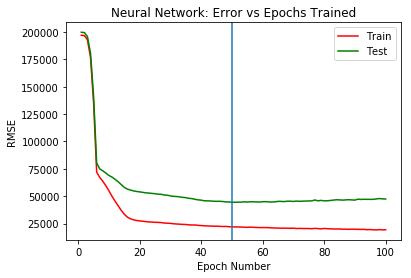

In [105]:
train_line = plt.plot(epochs,train_error, color='red', label='Train')
test_line = plt.plot(epochs,test_error, color='green', label='Test')
plt.title('Neural Network: Error vs Epochs Trained')
plt.ylabel('RMSE')
plt.xlabel('Epoch Number')
model_idx = np.argmin(test_error)
plt.axvline(x=model_idx)
plt.legend()

# Scatter Plots of predictions for all 3 models.

In [107]:
def plotScatter(predicted, name):
    colors = ["r", "b"]
    plt.title(name + " Predicted vs Actual Sale Price")
    plt.xlabel("Actual Sale Price")
    plt.ylabel("Predicted Sale Price")
    red_patch = mpatches.Patch(color='red', label='Actual Sale Price')
    blue_patch = mpatches.Patch(color='blue', label='Predicted Sale Price')
    plt.scatter(predicted['SalePrice'], predicted['predicted'], color="r", alpha=0.5)
    plt.show()


========== Prediction Scatter Plots Across Models ==========



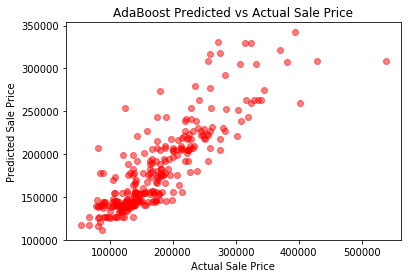

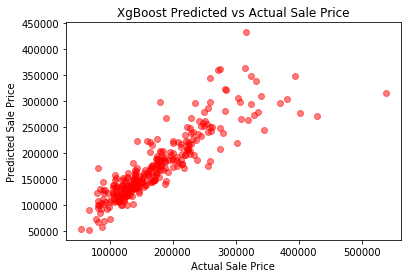

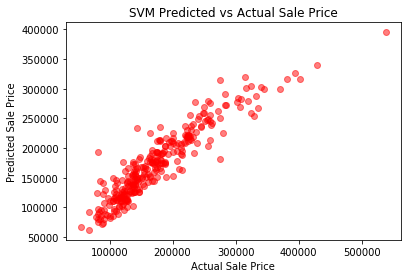

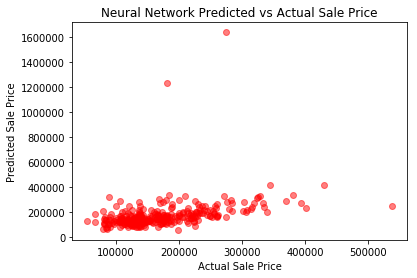

In [111]:
print()
print("========== Prediction Scatter Plots Across Models ==========")
print()

plotScatter(ada_pred, "AdaBoost")
plotScatter(xgb_pred, "XgBoost")
plotScatter(svr_pred, "SVM")
plotScatter(nn_pred, "Neural Network")

# Kaggle Submission

In [ ]:
kaggle_xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=70)

kaggle_xgb.fit(X_kaggle_train_pca, kaggle_train_y)

In [ ]:
kaggle_predicted = kaggle_xgb.predict(X_kaggle_test_pca)

In [ ]:
kaggle_predicted_complete = pd.DataFrame({'Id': kaggle_test["Id"], 'SalePrice': kaggle_predicted})

In [ ]:
kaggle_predicted_complete.to_csv('kaggle_predicted.csv', index=False)

# Tuning Hyperparameters

## Tunes AdaBoost/XGBoost n_estimators and SVR's C parameters.

In [ ]:
#This takes time (~2mins)
def tune_hyperparameters(X, Y, f):
    adaboost_param_tuning = pd.DataFrame(columns=['parameter', 'rmse'])
    xgb_param_tuning = pd.DataFrame(columns=['parameter', 'rmse'])    
    svr_param_tuning = pd.DataFrame(columns=['parameter', 'rmse'])    

    #Tuning n estimators parameter for boosting algorithms
    for i in range(25,200,25):
        print("Boosting: " + str(i))
        print()
        adaBoost = AdaBoostRegressor(n_estimators=i)
        print(adaBoost)
        k_fold_z, k_fold_mse, k_fold_rmse, bootstrapping_z, bootstrapping_mse, bootstrapping_rmse = evaluate_model(adaBoost, f, X, Y.values.ravel(), k=5, B=5)
        adaboost_param_tuning = adaboost_param_tuning.append({'parameter': i, 'rmse': k_fold_rmse}, ignore_index=True)
        print()
        
        xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=i)
        print(xgb)
        k_fold_z, k_fold_mse, k_fold_rmse, bootstrapping_z, bootstrapping_mse, bootstrapping_rmse = evaluate_model(xgb, f, X, Y.values.ravel(), k=5, B=5)
        xgb_param_tuning = xgb_param_tuning.append({'parameter': i, 'rmse': k_fold_rmse}, ignore_index=True)
        print()
        
    #for i in range(25,200,25):
    c_vals = [0.01, 0.1, 10, 100]
    for i in c_vals:
        print("C: " + str(i))
        print()
        svr_model = svm.SVR(kernel="poly", coef0=-2500, gamma="auto", C=i)
        print(svr_model)
        k_fold_z, k_fold_mse, k_fold_rmse, bootstrapping_z, bootstrapping_mse, bootstrapping_rmse = evaluate_model(svr_model, f, X, Y.values.ravel(), k=5, B=5)
        svr_param_tuning = svr_param_tuning.append({'parameter': i, 'rmse': k_fold_rmse}, ignore_index=True)
        print()

    return xgb_param_tuning, adaboost_param_tuning, svr_param_tuning

In [ ]:
print()
print("========== Hyper-Parameter Tuning ==========")
print()

xgb_params, adaboost_params, svm_params = tune_hyperparameters(kaggle_train_X_processed.values, kaggle_train_y, f)

print()
print("*** Hyper-parameter Tuning Complete! ***")
print()

### Plots how the changing of hyperparameters changes our models' root mean squared log errors.

In [ ]:
def plot_param_tuning(xgb_params, adaboost_params, svm_params):
    plt.plot(adaboost_params['parameter'], adaboost_params['rmse'], marker='o', color='b')
    plt.title("Adaboost RMSE vs n_estimators")
    plt.xlabel("n_estimators")
    plt.ylabel("RMSE")
    plt.show()
    
    plt.plot(xgb_params['parameter'], xgb_params['rmse'], marker='o', color='b')
    plt.title("XgBoost RMSE vs n_estimators")
    plt.xlabel("n_estimators")
    plt.ylabel("RMSE")
    plt.show()
    
    plt.plot(svm_params['parameter'], svm_params['rmse'], marker='o', color='b')
    plt.title("SVM RMSE vs C")
    plt.xlabel("C")
    plt.ylabel("RMSE")
    plt.show()

In [ ]:
print()
print("========== Parameter Tuning Plots ==========")
print()

plot_param_tuning(xgb_params, adaboost_params, svm_params)

## Tunes how many features to use from PCA.

In [ ]:
# This takes time to run (~5mins)
def pca_tuning(F, X, Y):
    
    pca_ada_frame = pd.DataFrame(columns=['pca', 'rmse'])
    pca_xg_frame = pd.DataFrame(columns=['pca', 'rmse'])
    pca_svr_frame = pd.DataFrame(columns=['pca', 'rmse'])
    
    for f in F:
        print("\nPCA %d" % f)

        # AdaBoost
        print("\n")
        from sklearn.ensemble import AdaBoostRegressor
        adaBoost = AdaBoostRegressor()
        k_z, k_mse, k_rmse, b_z, b_mse, b_rmse = evaluate_model(adaBoost, f, X.values, Y.values.ravel(), k=5, B=5)
        pca_ada_frame = pca_ada_frame.append({'pca': f, 'rmse': k_rmse}, ignore_index=True)


        # XGBoost Regressor
        print("\nXGBoost")
        from xgboost import XGBRegressor

        xgb = XGBRegressor(max_depth=3, learning_rate=0.2, booster='gbtree', n_estimators=70)

        k_z, k_mse, k_rmse, b_z, b_mse, b_rmse = evaluate_model(xgb, f, X.values, Y.values.ravel(), k=5, B=5)
        pca_xg_frame = pca_xg_frame.append({'pca': f, 'rmse': k_rmse}, ignore_index=True)

        
        # SVM (SVR)
        print("\nSVR")
        from sklearn import svm

        svr_model = svm.SVR(kernel="poly", coef0=-3500, gamma='auto')
        # coef0 only works with poly and sigmoid kernels
        # it just puts that value instead of the column of 1's

        # without it, this model breaks for some reason

        k_z, k_mse, k_rmse, b_z, b_mse, b_rmse = evaluate_model(svr_model, f, X.values, Y.values.ravel(), k=5, B=5)
        pca_svr_frame = pca_svr_frame.append({'pca': f, 'rmse': k_rmse}, ignore_index=True)
        
    return (pca_ada_frame, pca_xg_frame, pca_svr_frame)

### Plots how different amounts of PCA features affects our models' performances.

In [ ]:
def plot_pca_tuning(ada_data, xg_data, svr_data):
    plt.title("RMSE vs PCA Values across models")
    plt.xlabel("PCA Values")
    plt.ylabel("RMSE")
    plt.grid()
    plt.plot(ada_data['pca'], ada_data['rmse'], marker='o', color='r', label="Adaboost")
    plt.plot(xg_data['pca'], xg_data['rmse'], marker='o', color='g', label="XgBoost")
    plt.plot(svr_data['pca'], svr_data['rmse'], marker='o', color='b', label="SVR")
    
    plt.legend(loc='best')
    plt.show()

In [ ]:
print()
print("========== PCA Tuning ==========")
print()

pca_ada_frame, pca_xg_frame, pca_svr_frame = pca_tuning([30,35,40,45,50,55,60,65,70], kaggle_train_X_processed, kaggle_train_y)

print()
print("*** PCA Tuning Complete ***")
print()

In [ ]:
plot_pca_tuning(pca_ada_frame, pca_xg_frame, pca_svr_frame)

# Learning Curves

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [ ]:
print()
print("========== Learning Curves ==========")
print()
plot_learning_curve(estimator=adaBoost, title="Learning Curves (AdaBoost)", X=kaggle_train_X_processed, y=kaggle_train_y.values.ravel(), ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(estimator=xgb, title="Learning Curves (XgBoost)", X=kaggle_train_X_processed, y=kaggle_train_y.values.ravel(), ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
plot_learning_curve(estimator=svr_model, title="Learning Curves (SVR)", X=kaggle_train_X_processed, y=kaggle_train_y.values.ravel(), ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))